In [1]:
# CÉLULA 1: Montar Google Drive e Verificar GPU/Acesso

from google.colab import drive
import os
import torch

# 1. Montagem do Google Drive
print("Montando o Google Drive...")
drive.mount('/content/drive')
print("Drive montado com sucesso.")

# 2. Verificação Detalhada da GPU Alocada
print("\n--- STATUS DA GPU ---")
!nvidia-smi

# 3. Definição do Dispositivo
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Dispositivo de processamento: {DEVICE}")

# 4. Definição dos Caminhos
DATASET_PATH = '/content/drive/MyDrive/datasets/combined_full.json'
CHECKPOINT_DIR = "/content/drive/MyDrive/checkpoints"
CHECKPOINT_PATH_HYBRID = os.path.join(CHECKPOINT_DIR, "checkpoint_hybrid.pth")

# Criar o diretório de checkpoints
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Caminho do checkpoint configurado para: {CHECKPOINT_PATH_HYBRID}")

# 5. Verificação de Acesso
print(f"\nVerificando acesso ao dataset:")
!ls {DATASET_PATH}

Montando o Google Drive...
Mounted at /content/drive
Drive montado com sucesso.

--- STATUS DA GPU ---
Tue Nov 11 12:25:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                    

In [2]:
# Instalações (se necessário, como para transformers, mas vamos supor que o PyTorch/sklearn já estão lá)
# Se você usa a biblioteca 'transformers', pode precisar:
# !pip install transformers

# --- Importações Essenciais ---
import json
import pandas as pd
import torch
import time # Necessário para medir o Tempo de Inferência
from sklearn.model_selection import KFold # Essencial para a Validação Cruzada
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Para métricas por fold
from torch.utils.data import DataLoader, Dataset # Para gerenciar os dados no PyTorch

# --- Carregamento e Limpeza Inicial do DataFrame ---

# 1. Carregar o arquivo JSON
print(f"Carregando dados de: {DATASET_PATH}")
with open(DATASET_PATH, 'r') as file:
    data = json.load(file)

# 2. Converter para DataFrame e Separar Features/Labels
df = pd.json_normalize(data)

# Separar features (coluna 'text') e label (coluna 'label')
X = df['text']
y = df['label']

# 3. Limpeza Inicial (Remover prefixos http/www)
print("Realizando limpeza inicial de URLs...")
X = X.str.replace(r'http[s]?://', '', regex=True)
X = X.str.replace(r'www\.', '', regex=True)

# 4. Conferir as primeiras linhas para validação
print("\n--- Dados Carregados e Limpos (Amostra) ---")
print(X.head())
print(y.head())
print(f"\nTotal de amostras carregadas: {len(X)}")

# Agora temos as variáveis globais X e y prontas para tokenização/K-Fold

Carregando dados de: /content/drive/MyDrive/datasets/combined_full.json
Realizando limpeza inicial de URLs...

--- Dados Carregados e Limpos (Amostra) ---
0    applevalleyhyundai.org/slug/c/casio-ctk-630-el...
1    hannibal.net/news_local/x342379827/Illinois-Ri...
2          linkedin.com/company/taipei-american-school
3                                        wwwgoogle.ro/
4                       ganges.com/rss/videos_top.html
Name: text, dtype: object
0    0
1    0
2    0
3    1
4    0
Name: label, dtype: int64

Total de amostras carregadas: 871590


In [3]:
# CÉLULA 3: Funções Auxiliares (Carregamento do Modelo e Avaliação)

import os
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F # Embora não usemos diretamente F, mantemos para consistência

# --- 1. FUNÇÃO DE CARREGAMENTO DO CHECKPOINT HÍBRIDO ---
# Usaremos APENAS para carregar o modelo treinado, não o otimizador/scheduler.

def load_model_from_checkpoint(model, filename, device):
    """
    Carrega apenas os pesos do modelo (state_dict) a partir de um checkpoint.
    """
    if os.path.isfile(filename):
        # map_location garante que o carregamento funcione independente da GPU
        checkpoint = torch.load(filename, map_location=device)

        # Carrega apenas o estado do modelo
        model.load_state_dict(checkpoint['model_state_dict'])

        print(f"Pesos do modelo HÍBRIDO carregados com sucesso de: {filename}")
    else:
        # Se o checkpoint não for encontrado, levanta um erro, pois precisamos dele para K-Fold/Inferência
        raise FileNotFoundError(f"ERRO: Checkpoint não encontrado no caminho: {filename}")


# --- 2. FUNÇÃO DE AVALIAÇÃO (Reutilizada e Adaptada para K-Fold) ---

def evaluate(model, data_loader, device):
    """
    Avalia o modelo em um DataLoader e retorna a perda, acurácia e, o mais importante
    para o artigo, todas as previsões e rótulos reais.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Avaliando batches'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs

            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Armazena todas as previsões e rótulos reais para cálculo de métricas avançadas
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total

    return avg_loss, accuracy, all_preds, all_labels

In [4]:
# CÉLULA 4 (ADAPTADA para K-Fold): Tokenização e Criação do Dataset Completo

from transformers import DistilBertTokenizerFast
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# --- 1. CARREGAR O TOKENIZER ---
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# --- 2. TOKENIZAÇÃO OTIMIZADA DO DATASET COMPLETO ---
# X e y (dados completos) são definidos na Célula 2
texts = X.tolist()
labels = y.tolist()
max_len = 128

def tokenize_full_dataset(texts, labels):
    """Tokeniza o dataset completo usando a estratégia de chunks."""
    encodings = {'input_ids': [], 'attention_mask': []}

    # Chunk size de 5000: mantém a otimização de RAM
    CHUNK_SIZE = 5000
    print(f"Iniciando tokenização em partes (chunks de {CHUNK_SIZE}) do dataset completo...")

    for i in tqdm(range(0, len(texts), CHUNK_SIZE), desc="Tokenizando Chunks"):
        chunk_texts = texts[i:i + CHUNK_SIZE]

        # Tokenização
        chunk_encodings = tokenizer(
            chunk_texts,
            truncation=True,
            padding='max_length',
            max_length=max_len
        )

        # Anexar os resultados
        for key in chunk_encodings:
            encodings[key].extend(chunk_encodings[key])

    return encodings, labels

# Tokenizar o Dataset Completo
full_encodings, full_labels = tokenize_full_dataset(texts, labels)

# --- 3. CLASSE DATASET CUSTOMIZADA (mantida) ---
class PhishingDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Transforma a parte relevante do encoding em tensor
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# --- 4. CRIAÇÃO DO DATASET COMPLETO ---
# Este dataset será a base para o K-Fold na próxima célula
FULL_DATASET = PhishingDataset(full_encodings, full_labels)

print("\nDataset Completo (FULL_DATASET) criado e pronto para Validação K-Fold.")
print(f"Número total de amostras no FULL_DATASET: {len(FULL_DATASET)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Iniciando tokenização em partes (chunks de 5000) do dataset completo...


Tokenizando Chunks: 100%|██████████| 175/175 [11:02<00:00,  3.79s/it]


Dataset Completo (FULL_DATASET) criado e pronto para Validação K-Fold.
Número total de amostras no FULL_DATASET: 871590


In [5]:
# CÉLULA 5: Confirmação do Tamanho Total do Dataset

# O FULL_DATASET foi criado na Célula 4
TAMANHO_TOTAL = len(FULL_DATASET)
BATCH_SIZE = 16 # Mantendo o Batch Size

print("--- Confirmação do Dataset Completo para K-Fold ---")
print(f"Número total de amostras no FULL_DATASET: {TAMANHO_TOTAL}")
print(f"Número aproximado de batches (com Batch Size {BATCH_SIZE}): {TAMANHO_TOTAL // BATCH_SIZE}")

--- Confirmação do Dataset Completo para K-Fold ---
Número total de amostras no FULL_DATASET: 871590
Número aproximado de batches (com Batch Size 16): 54474


In [10]:
# CÉLULA 6: Definição da Arquitetura Híbrida (HybridPhishingModel) - VERIFICADA

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import DistilBertModel

# --- 1. DEFINIÇÃO DA CLASSE DO MODELO HÍBRIDO ---
class HybridPhishingModel(nn.Module):
    def __init__(self, num_labels=2):
        super(HybridPhishingModel, self).__init__()

        # 1. Componente DistilBERT (Contextual)
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        hidden_size = self.distilbert.config.hidden_size # 768

        # 2. Componente CNN (Local Features)
        # ... (restante das camadas CNN e LSTM) ...
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=100, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=hidden_size, out_channels=100, kernel_size=4)
        self.conv3 = nn.Conv1d(in_channels=hidden_size, out_channels=100, kernel_size=5)
        cnn_out_size = 300

        # 3. Componente RNN (LSTM Bidirecional)
        lstm_hidden_size = 128
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=lstm_hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )
        lstm_out_size = 2 * lstm_hidden_size

        # 4. Camada de Classificação Final (MLP)
        final_input_size = cnn_out_size + lstm_out_size
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(final_input_size, num_labels)

    def forward(self, input_ids, attention_mask):
        # 1. Obter embeddings do DistilBERT
        bert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        # --- 2. Passagem pela CNN ---
        bert_output_cnn = bert_output.permute(0, 2, 1)
        c1 = torch.max(F.relu(self.conv1(bert_output_cnn)), dim=2)[0]
        c2 = torch.max(F.relu(self.conv2(bert_output_cnn)), dim=2)[0]
        c3 = torch.max(F.relu(self.conv3(bert_output_cnn)), dim=2)[0]
        cnn_features = torch.cat((c1, c2, c3), dim=1)

        # --- 3. Passagem pela RNN (LSTM) ---
        lstm_output, (hn, cn) = self.lstm(bert_output)
        lstm_features = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1)

        # --- 4. CLASSIFICAÇÃO FINAL ---
        combined_features = torch.cat((cnn_features, lstm_features), dim=1)
        output = self.dropout(combined_features)
        logits = self.classifier(output)

        return logits # <--- Retorno dos logits

print("Modelo Híbrido HybridPhishingModel definido com sucesso!")

Modelo Híbrido HybridPhishingModel definido com sucesso!


In [11]:
# CÉLULA 7: Inicialização do Modelo, Carregamento de Pesos e Configuração do K-Fold

from sklearn.model_selection import KFold

# --- 1. INICIALIZAÇÃO DO MODELO E CARREGAMENTO ---
# model_hybrid é instanciado na Célula 6
# DEVICE e CHECKPOINT_PATH_HYBRID vêm da Célula 1

print("Inicializando Modelo Híbrido...")
model_hybrid = HybridPhishingModel(num_labels=2)
model_hybrid.to(DEVICE)

# Carregar os pesos (model_state_dict) usando a função da Célula 3
try:
    load_model_from_checkpoint(
        model=model_hybrid,
        filename=CHECKPOINT_PATH_HYBRID,
        device=DEVICE
    )
except FileNotFoundError as e:
    print(e)
    print("\nAVISO: O K-Fold não pode prosseguir sem o modelo treinado. Por favor, verifique o caminho.")
    # Se ocorrer um erro, o script pode parar aqui para evitar erros futuros.
    # raise e # Descomente para parar o notebook em caso de erro

# --- 2. CONFIGURAÇÃO DO K-FOLD ---
# Define o número de folds (K)
N_SPLITS = 5 # Um valor comum (5-Fold Cross-Validation)

print(f"\nConfigurando Validação Cruzada K-Fold com K={N_SPLITS}...")

# Inicializa o objeto KFold.
# 'shuffle=True' garante que os dados são misturados antes da divisão.
# 'random_state=42' garante que a divisão seja a mesma em execuções repetidas.
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# O K-Fold usará os índices do FULL_DATASET para dividir em Treino e Validação.
print("Objeto KFold configurado e pronto para o loop.")

Inicializando Modelo Híbrido...
Pesos do modelo HÍBRIDO carregados com sucesso de: /content/drive/MyDrive/checkpoints/checkpoint_hybrid.pth

Configurando Validação Cruzada K-Fold com K=5...
Objeto KFold configurado e pronto para o loop.


In [12]:
# CÉLULA 8: Loop K-Fold, Avaliação e Coleta de Métricas

from torch.utils.data import Subset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Variáveis globais:
# FULL_DATASET (Célula 4), kf (Célula 7), model_hybrid (Célula 7), DEVICE (Célula 1)
BATCH_SIZE = 16

# Listas para armazenar as métricas de cada fold
metrics_results = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1_Score': []
}

print(f"Iniciando Validação Cruzada {kf.n_splits}-Fold...")
print("-" * 50)

for fold, (train_index, val_index) in enumerate(kf.split(FULL_DATASET)):
    print(f"🌟 FOLD {fold+1}/{kf.n_splits}")

    # 1. Criação dos Subdatasets e DataLoaders para o fold
    # Usamos os índices para criar subconjuntos do FULL_DATASET
    val_subset = Subset(FULL_DATASET, val_index)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE)

    print(f"   Amostras de Validação: {len(val_subset)}")

    # OBS: O modelo JÁ ESTÁ TREINADO. O loop K-Fold apenas o avalia nos novos splits.

    # 2. Avaliação do Modelo no Fold de Validação
    # A função 'evaluate' vem da Célula 3
    val_loss, val_acc, all_preds, all_labels = evaluate(
        model=model_hybrid,
        data_loader=val_loader,
        device=DEVICE
    )

    # 3. Cálculo das Métricas Scikit-Learn (Mais detalhado que a Acurácia simples)
    # Average='binary' ou 'weighted' dependendo da sua necessidade. Usaremos 'weighted' como padrão
    # para lidar com possíveis desequilíbrios na amostra de validação de cada fold.
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    # 4. Armazenamento dos Resultados
    metrics_results['Accuracy'].append(val_acc)
    metrics_results['Precision'].append(precision)
    metrics_results['Recall'].append(recall)
    metrics_results['F1_Score'].append(f1)

    print(f"   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f}")
    print("-" * 50)

# --- 5. Resultados Finais do K-Fold ---
print("✅ RESULTADOS FINAIS DA VALIDAÇÃO CRUZADA:")
print("-" * 50)

# Cálculo da Média e Desvio Padrão
for metric_name, values in metrics_results.items():
    mean = np.mean(values)
    std = np.std(values)

    print(f"   {metric_name}: Média = {mean:.4f} (± Desvio Padrão = {std:.4f})")

print("-" * 50)

Iniciando Validação Cruzada 5-Fold...
--------------------------------------------------
🌟 FOLD 1/5
   Amostras de Validação: 174318


Avaliando batches: 100%|██████████| 10895/10895 [10:58<00:00, 16.54it/s]


   Loss: 0.0167 | Acc: 0.9955 | Prec: 0.9955 | Rec: 0.9955 | F1: 0.9955
--------------------------------------------------
🌟 FOLD 2/5
   Amostras de Validação: 174318


Avaliando batches: 100%|██████████| 10895/10895 [10:57<00:00, 16.57it/s]


   Loss: 0.0181 | Acc: 0.9952 | Prec: 0.9952 | Rec: 0.9952 | F1: 0.9952
--------------------------------------------------
🌟 FOLD 3/5
   Amostras de Validação: 174318


Avaliando batches: 100%|██████████| 10895/10895 [10:57<00:00, 16.58it/s]


   Loss: 0.0182 | Acc: 0.9951 | Prec: 0.9951 | Rec: 0.9951 | F1: 0.9951
--------------------------------------------------
🌟 FOLD 4/5
   Amostras de Validação: 174318


Avaliando batches: 100%|██████████| 10895/10895 [10:57<00:00, 16.56it/s]


   Loss: 0.0171 | Acc: 0.9957 | Prec: 0.9957 | Rec: 0.9957 | F1: 0.9957
--------------------------------------------------
🌟 FOLD 5/5
   Amostras de Validação: 174318


Avaliando batches: 100%|██████████| 10895/10895 [10:57<00:00, 16.58it/s]


   Loss: 0.0171 | Acc: 0.9953 | Prec: 0.9954 | Rec: 0.9953 | F1: 0.9953
--------------------------------------------------
✅ RESULTADOS FINAIS DA VALIDAÇÃO CRUZADA:
--------------------------------------------------
   Accuracy: Média = 0.9954 (± Desvio Padrão = 0.0002)
   Precision: Média = 0.9954 (± Desvio Padrão = 0.0002)
   Recall: Média = 0.9954 (± Desvio Padrão = 0.0002)
   F1_Score: Média = 0.9954 (± Desvio Padrão = 0.0002)
--------------------------------------------------


In [13]:
# CÉLULA 9: Cálculo do Tempo de Inferência

import time
import torch
from torch.utils.data import DataLoader, Subset
import numpy as np

# Variáveis globais:
# FULL_DATASET (Célula 4), model_hybrid (Célula 7), DEVICE (Célula 1)
BATCH_SIZE_INFERENCE = 1 # Usamos batch size 1 para medir o tempo de predição individual mais precisamente
SAMPLES_TO_TEST = 1000 # Número de amostras a serem usadas para a medição (Ajuste conforme necessário)

print("--- Cálculo do Tempo de Inferência ---")

# 1. Selecionar um subconjunto de amostras para o teste
if len(FULL_DATASET) < SAMPLES_TO_TEST:
    SAMPLES_TO_TEST = len(FULL_DATASET)
    print(f"Aviso: Reduzindo amostras de teste para o tamanho total do dataset: {SAMPLES_TO_TEST}")

# Criação de índices para o subconjunto (pegando as primeiras SAMPLES_TO_TEST amostras)
inference_indices = list(range(SAMPLES_TO_TEST))
inference_subset = Subset(FULL_DATASET, inference_indices)
inference_loader = DataLoader(inference_subset, batch_size=BATCH_SIZE_INFERENCE, shuffle=False)

# 2. Configurar o modelo para avaliação
model_hybrid.eval()

# 3. Medição do Tempo
start_time = time.time() # Tempo inicial

with torch.no_grad():
    # Iterar sobre o subconjunto e fazer a inferência
    for batch in inference_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)

        # Executar a predição (forward pass)
        _ = model_hybrid(input_ids=input_ids, attention_mask=attention_mask)

end_time = time.time() # Tempo final

# 4. Cálculo e Apresentação dos Resultados
total_time = end_time - start_time
average_time_per_sample = total_time / SAMPLES_TO_TEST

print(f"\nNúmero de amostras testadas: {SAMPLES_TO_TEST}")
print(f"Tempo total de inferência (s): {total_time:.4f} segundos")
print(f"Tempo médio de inferência por amostra (ms): {average_time_per_sample * 1000:.4f} milissegundos")

print("\nCálculo do Tempo de Inferência concluído. Resultados prontos para o artigo.")

--- Cálculo do Tempo de Inferência ---

Número de amostras testadas: 1000
Tempo total de inferência (s): 6.9147 segundos
Tempo médio de inferência por amostra (ms): 6.9147 milissegundos

Cálculo do Tempo de Inferência concluído. Resultados prontos para o artigo.


Instalando bibliotecas de visualização...

--- SUMÁRIO DOS RESULTADOS FINAIS ---

Resultados da Validação Cruzada K-Fold:
           Média  Desvio Padrão
Accuracy  0.9954         0.0002
Precision 0.9954         0.0002
Recall    0.9954         0.0002
F1_Score  0.9954         0.0002

Tempo Médio de Inferência por Amostra: 6.9147 ms
Tempo Total de Inferência para 1000 amostras: 6.9147 segundos

--- Gerando Gráficos dos Resultados K-Fold ---


/tmp/ipython-input-439019803.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kfold_summary.index, y=kfold_summary['Média'], palette='viridis')


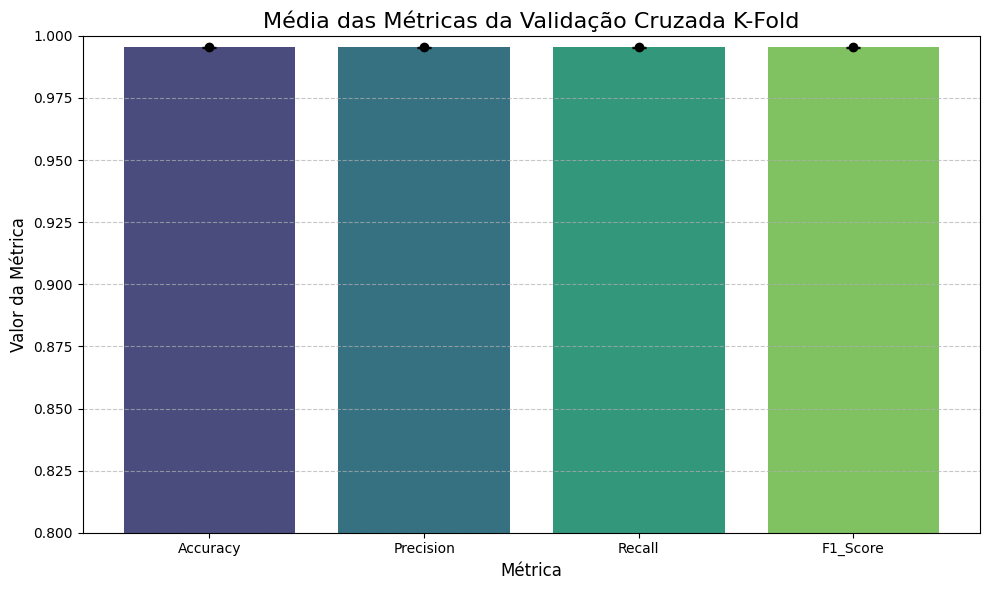

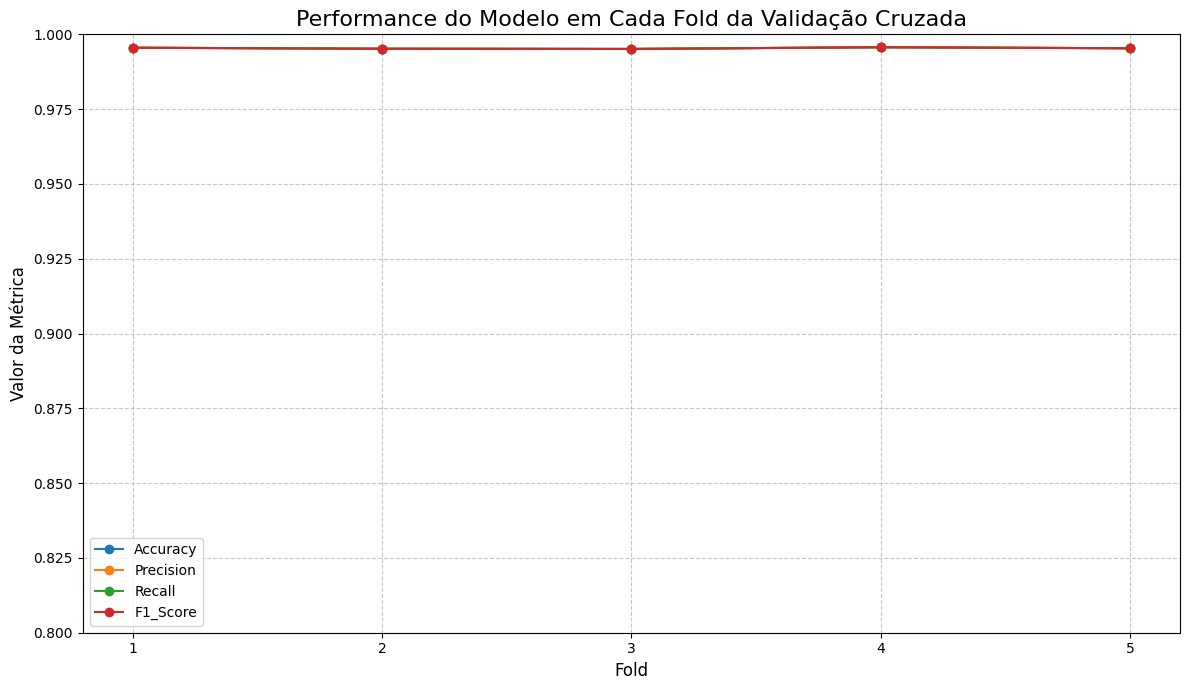


Visualizações concluídas.


In [14]:
# CÉLULA 10: Exibição e Visualização dos Resultados Finais

# --- INSTALAÇÃO DE DEPENDÊNCIAS DE VISUALIZAÇÃO ---
print("Instalando bibliotecas de visualização...")
!pip install matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n--- SUMÁRIO DOS RESULTADOS FINAIS ---")

# 1. Resultados da Validação Cruzada K-Fold (da Célula 8)
# Criar um DataFrame para as métricas do K-Fold
kfold_summary = pd.DataFrame({
    'Média': {metric: np.mean(values) for metric, values in metrics_results.items()},
    'Desvio Padrão': {metric: np.std(values) for metric, values in metrics_results.items()}
})

print("\nResultados da Validação Cruzada K-Fold:")
print(kfold_summary.to_string(float_format="%.4f"))

# 2. Resultados do Tempo de Inferência (da Célula 9)
# Assumimos que 'average_time_per_sample' e 'total_time' foram definidos na Célula 9
print(f"\nTempo Médio de Inferência por Amostra: {average_time_per_sample * 1000:.4f} ms")
print(f"Tempo Total de Inferência para {SAMPLES_TO_TEST} amostras: {total_time:.4f} segundos")

# --- VISUALIZAÇÕES GRÁFICAS ---
print("\n--- Gerando Gráficos dos Resultados K-Fold ---")

# Gráfico 1: Barras para as Métricas Médias (com Barras de Erro)
plt.figure(figsize=(10, 6))
sns.barplot(x=kfold_summary.index, y=kfold_summary['Média'], palette='viridis')
plt.errorbar(x=kfold_summary.index, y=kfold_summary['Média'], yerr=kfold_summary['Desvio Padrão'],
             fmt='o', color='black', capsize=5)
plt.title('Média das Métricas da Validação Cruzada K-Fold', fontsize=16)
plt.ylabel('Valor da Métrica', fontsize=12)
plt.xlabel('Métrica', fontsize=12)
plt.ylim(0.8, 1.0) # Ajuste o limite Y conforme a expectativa de suas métricas
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Gráfico 2: Performance por Fold
plt.figure(figsize=(12, 7))
metric_names = list(metrics_results.keys())
num_folds = len(metrics_results['Accuracy'])
folds = np.arange(1, num_folds + 1)

for metric in metric_names:
    plt.plot(folds, metrics_results[metric], marker='o', label=metric)

plt.title('Performance do Modelo em Cada Fold da Validação Cruzada', fontsize=16)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Valor da Métrica', fontsize=12)
plt.xticks(folds)
plt.ylim(0.8, 1.0) # Ajuste conforme necessário
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nVisualizações concluídas.")